# Notebook Splits Data into Seasons (warm and cold) and fits a random forest to each

In [1]:
# %matplotlib widget
import numpy as np 
import matplotlib.pyplot as plt 
import math
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
# Error computer 
from score_regression import compute_scores

In [2]:
def plotRegression(truth, pred):
    plt.figure(figsize=(10,10))
    plt.scatter(truth, pred)
    plt.grid()
    plt.xlabel("Truth (KW)")
    plt.ylabel("Predicted (KW)")
    plt.title("Truth Plotted against actual value")
    plt.plot([min(truth),max(truth)], [min(truth),max(truth)], 'r')
    plt.show()
    
def computeAverageError(pred, y):
    err = []
    for i in range(len(pred)):
        err.append(abs((y[i] - pred[i])/(y[i] + 1e-6)))

    return sum(err)/ len(err)

### Load Data, Split into Warm and Cold Season

In [3]:
data_unscaled_filename = '/Users/brad/Desktop/CS6620/Project/Data/combined_processed_data1.csv' 
data = pd.read_csv(data_unscaled_filename, sep=',')
data.drop('Unnamed: 0',axis=1, inplace=True)

In [4]:
warm_season = data.loc[(data['Month'] >= 4) & (data['Month'] <= 9)]

In [5]:
cold_season = data.loc[(data['Month'] < 4)]

In [6]:
cold_season = cold_season.append(data.loc[(data['Month'] > 9)], ignore_index= True)

### Split into train, test sets

In [7]:
# Warm Season 
y_warm = warm_season['Solar_average'].to_numpy()
x_warm = warm_season.drop(['date_time', 'Solar_average', 'Solar_total', 'Count'], axis=1).to_numpy()
# 0.85 - 0.15 split
warm_train_length = int(x_warm.shape[0]*0.85)

x_train_warm = x_warm[0 : warm_train_length].reshape(-1, x_warm.shape[1])
x_test_warm = x_warm[warm_train_length :].reshape(-1, x_warm.shape[1])
y_train_warm = y_warm[0 : warm_train_length].reshape(-1,1)
y_test_warm = y_warm[warm_train_length : ].reshape(-1,1)

In [8]:
# Cold Season
y_cold = cold_season['Solar_average'].to_numpy()
x_cold = cold_season.drop(['date_time', 'Solar_average', 'Solar_total', 'Count'], axis=1).to_numpy()
# 0.85 - 0.15 split
cold_train_length = int(x_cold.shape[0]*0.85)

x_train_cold = x_cold[0 : cold_train_length].reshape(-1, x_cold.shape[1])
x_test_cold = x_cold[cold_train_length :].reshape(-1, x_cold.shape[1])
y_train_cold = y_cold[0 : cold_train_length].reshape(-1,1)
y_test_cold = y_cold[cold_train_length : ].reshape(-1,1)

### Scale Data

In [9]:
# Scale Warm
x_warm_scaler = MinMaxScaler()
x_warm_scaler.fit(x_train_warm)
x_train_warm = x_warm_scaler.transform(x_train_warm)
x_test_warm = x_warm_scaler.transform(x_test_warm)

y_warm_scaler = QuantileTransformer(output_distribution='uniform')
y_warm_scaler.fit(y_train_warm)
y_train_warm = y_warm_scaler.transform(y_train_warm)
y_test_warm = y_warm_scaler.transform(y_test_warm)

In [10]:
# Scale Cold
x_cold_scaler = MinMaxScaler()
x_cold_scaler.fit(x_train_cold)
x_train_cold = x_cold_scaler.transform(x_train_cold)
x_test_cold = x_cold_scaler.transform(x_test_cold)

y_cold_scaler = QuantileTransformer(output_distribution='uniform')
y_cold_scaler.fit(y_train_cold)
y_train_cold = y_cold_scaler.transform(y_train_cold)
y_test_cold = y_cold_scaler.transform(y_test_cold)

### Fit Random Forest

#### Warm Season

In [12]:
warm_random_forest = RandomForestRegressor(n_estimators=100, random_state=0)
warm_random_forest.fit(x_train_warm, y_train_warm)
# Prediction and r2 on training 
y_warm_train_pred = warm_random_forest.predict(x_train_warm).reshape(-1,1)
# print(r2_score(y_train_warm, y_warm_train_pred))
y_warm_test_pred = warm_random_forest.predict(x_test_warm).reshape(-1,1)
# print(r2_score(y_test_warm, y_warm_test_pred))
print("sklearn error metrics")
print(compute_scores(y_train_warm, y_warm_train_pred))
print(compute_scores(y_test_warm, y_warm_test_pred))

/Users/brad/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
sklearn error metrics
{'r2': 0.9933516468181263, 'MAE': 0.01451055449949551, 'MSE': 0.0005546068723073885, 'MedianAE': 0.008974814648589735, 'ExpVar': 0.9933521810632059}
{'r2': 0.954664022328902, 'MAE': 0.04528599886783921, 'MSE': 0.00337390480626344, 'MedianAE': 0.03680053423063556, 'ExpVar': 0.962133176754243}


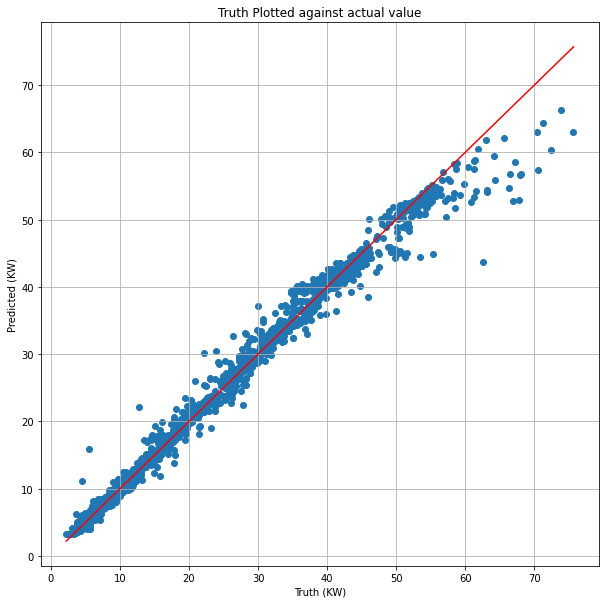

In [28]:
plotRegression(y_warm_scaler.inverse_transform(y_train_warm)/1000, y_warm_scaler.inverse_transform(y_warm_train_pred)/1000)

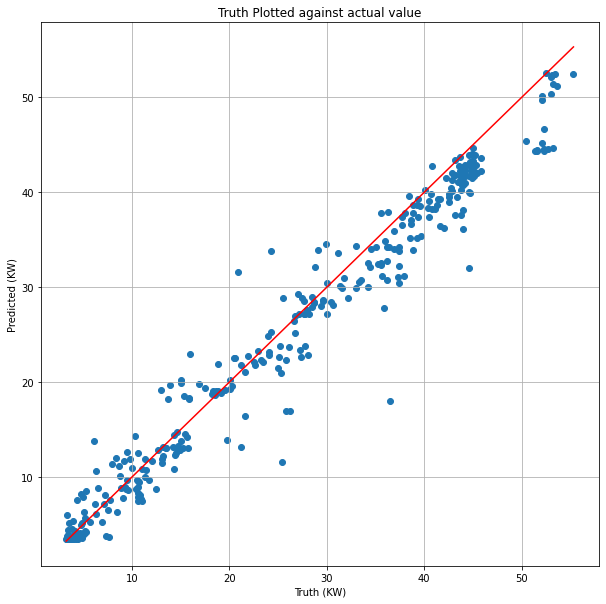

In [34]:
plotRegression(y_warm_scaler.inverse_transform(y_test_warm)/1000, y_warm_scaler.inverse_transform(y_warm_test_pred)/1000)

#### Cold Season

In [13]:
cold_random_forest = RandomForestRegressor(n_estimators=100, random_state=2)
cold_random_forest.fit(x_train_cold, y_train_cold.ravel())
# Prediction and r2 on training 
y_cold_train_pred = cold_random_forest.predict(x_train_cold).reshape(-1,1)
# print(r2_score(y_train_cold, y_cold_train_pred))
y_cold_test_pred = cold_random_forest.predict(x_test_cold).reshape(-1,1)
# print(r2_score(y_test_cold, y_cold_test_pred))
print("sklearn error metrics")
print(compute_scores(y_train_cold, y_cold_train_pred))
print(compute_scores(y_test_cold, y_cold_test_pred))

sklearn error metrics
{'r2': 0.981503388993134, 'MAE': 0.0266019608304949, 'MSE': 0.0015424632752012951, 'MedianAE': 0.01710742698565698, 'ExpVar': 0.9815060383517025}
{'r2': 0.7857389043394123, 'MAE': 0.09565911696986366, 'MSE': 0.01659687583799, 'MedianAE': 0.07434012820357938, 'ExpVar': 0.8052040780415752}


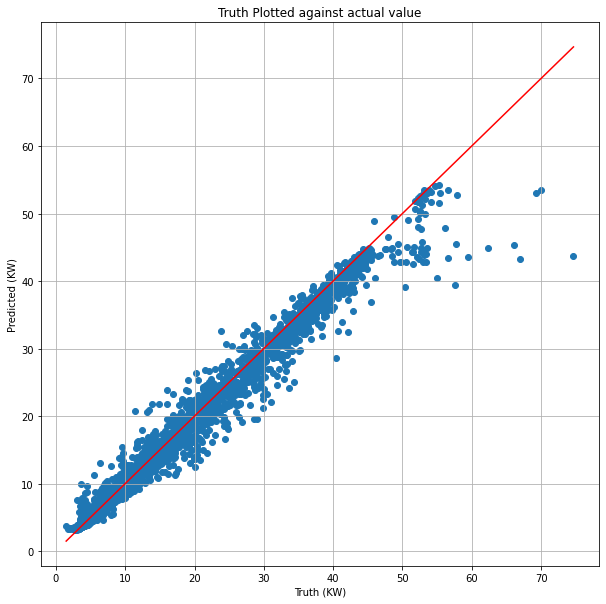

In [42]:
plotRegression(y_cold_scaler.inverse_transform(y_train_cold)/1000, y_cold_scaler.inverse_transform(y_cold_train_pred)/1000)

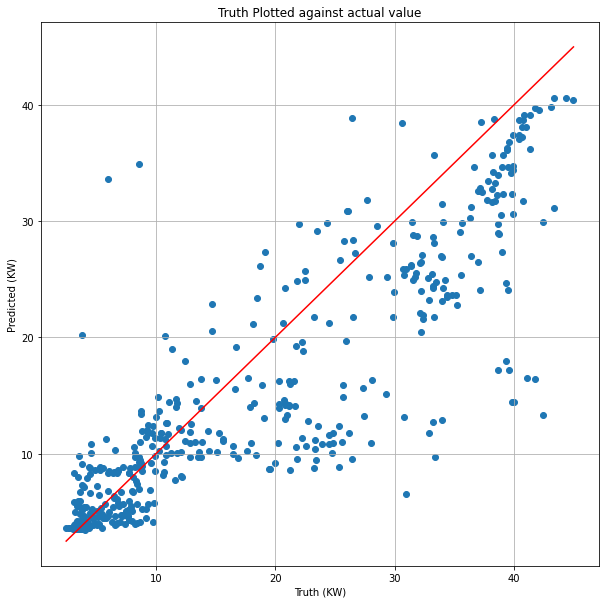

In [43]:
plotRegression(y_cold_scaler.inverse_transform(y_test_cold)/1000, y_cold_scaler.inverse_transform(y_cold_test_pred)/1000)